# Информация
Для решения поставленной задачи использовался подход transfer learning. Было дообучено несколько моделей (resnet, efficientnet и другие), но наилучшие результаты показал vision transformer, а именно ViT_l_16 из библиотеки torchvision

Были попытки дообучить трансформер с большим разрешением входных картинок (512x512), но модель непозволительно долго обучалась, поэтому выбор остановился на указанной выше модели.

# Импорты и загрузка данных

In [3]:
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import F1Score
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from PIL import Image

import glob
import time
from tqdm import tqdm
from IPython.display import display

import pandas as pd
import numpy as np

from google.colab import drive


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.has_mps:
    device = torch.device("mps")
else:
    device = torch.device('cpu')

print(device)

cuda


Архив с данными был загружен на гугл диск, следующие команды необходимы для разархивирования и считывания этих данных

In [4]:
DATASET_PATH = "/content/drive/MyDrive/cv_contest_dataset/"

drive.mount('/content/drive')
!unzip -u "$DATASET_PATH"vk-made-sports-image-classification.zip -d "$DATASET_PATH"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/cv_contest_dataset/vk-made-sports-image-classification.zip
/content/drive/MyDrive/cv_contest_dataset/test/00043dc0-09ad-4f3f-9c8b-e7bbd0d2bacf.jpeg exists and is a symbolic link with no real file.
replace /content/drive/MyDrive/cv_contest_dataset/test/00043dc0-09ad-4f3f-9c8b-e7bbd0d2bacf.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/cv_contest_dataset/test/00043dc0-09ad-4f3f-9c8b-e7bbd0d2bacf.jpeg  
  inflating: /content/drive/MyDrive/cv_contest_dataset/train/0001edd2-e2a0-4d38-a386-8f365a9586e8.jpeg  


# Подготовка данных для обучения трансформера ViT_l_16
Проведем преобразование входных данных, согласно документации:

*The inference transforms are available at ViT_L_16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[242] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].*

In [5]:
class ImageDataset(Dataset):
    def __init__(self, dataset_path, train_or_test, labels_to_idx, transform=None):
        self.data_dir = dataset_path
        self.train_or_test = train_or_test
        self.img_paths = [img_path for img_path in glob.glob(dataset_path + train_or_test + "/" + '*')]
        self.data_info = pd.read_csv(self.data_dir + f"{train_or_test}.csv")
        self.labels_to_idx = labels_to_idx
        self.transform = transform

    def __getitem__(self, idx):
        image_id = self.img_paths[idx][len(self.data_dir) + len(self.train_or_test) + 1:]
        image = Image.open(f'{self.data_dir}' + f'{self.train_or_test}' + "/" + f'{image_id}').convert('RGB')

        if self.transform:
            image = self.transform(image)
        img_info = self.data_info[self.data_info["image_id"] == image_id]
        if self.train_or_test == "test":
            return image, image_id
        return image, torch.tensor(self.labels_to_idx[img_info.values.tolist()[0][1]], dtype=torch.int64)

    def __len__(self):
        return len(self.img_paths)

Считываем лейблы, считаем общее число классов и сопоставляем лейблы с их индексами

In [6]:
LABELS = np.sort(pd.read_csv(DATASET_PATH + "train.csv")['label'].unique())
N_CLASSES = len(LABELS)

labels_to_idx = {}
idx_to_label = {}

for i, label in enumerate(LABELS):
    labels_to_idx[label] = i
    idx_to_label[i] = label

Посмотрим на картинки

In [7]:
default_transform = transforms.Compose([
    transforms.Resize((242,242), interpolation=transforms.InterpolationMode.BICUBIC)
    ])

resized_train_data = ImageDataset(DATASET_PATH, "train", labels_to_idx, default_transform)

velo


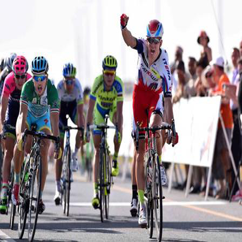

In [8]:
def show_image(data, idx_to_label, train_or_test, img_idx=0, transformed=False):
    img = data[img_idx]
    if train_or_test == "train":
        print(idx_to_label[img[1].item()])
        img = img[0]
    if transformed:
            img = transforms.ToPILImage()(img).convert("RGB")
    display(img)


show_image(resized_train_data, idx_to_label, "train", 0, transformed=False)

Преобразуем данные с необходимыми параметрами

In [9]:
normalization = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

final_transform = transforms.Compose([
    transforms.Resize((242,242), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop([224]),
    transforms.ToTensor(),
    normalization
])

transformed_train_data = ImageDataset(DATASET_PATH, "train", labels_to_idx, final_transform)

velo


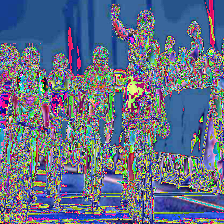

In [10]:
show_image(transformed_train_data, idx_to_label, "train", 0, transformed=True)

In [11]:
transformed_train_data[0]

(tensor([[[ 2.0948,  2.0948,  2.0948,  ...,  2.1633,  2.1633,  2.1633],
          [ 2.0948,  2.0948,  2.0948,  ...,  2.1633,  2.1633,  2.1633],
          [ 2.0948,  2.0948,  2.0948,  ...,  2.1633,  2.1633,  2.1633],
          ...,
          [ 0.9132,  0.9474,  0.7591,  ..., -0.9020, -0.9192, -0.8507],
          [ 0.9132,  0.8618,  0.9474,  ..., -0.6281, -0.6965, -0.7137],
          [ 1.0331,  1.0331,  0.9817,  ...,  0.6392,  0.5878,  0.5536]],
 
         [[ 2.2535,  2.2535,  2.2535,  ...,  2.3410,  2.3410,  2.3410],
          [ 2.2535,  2.2535,  2.2535,  ...,  2.3410,  2.3410,  2.3410],
          [ 2.2535,  2.2535,  2.2535,  ...,  2.3410,  2.3410,  2.3410],
          ...,
          [ 0.9580,  1.0105,  0.8354,  ..., -0.7927, -0.8277, -0.7577],
          [ 0.9230,  0.8704,  0.9930,  ..., -0.5126, -0.5826, -0.6001],
          [ 1.0105,  1.0105,  1.0105,  ...,  0.7829,  0.7304,  0.6954]],
 
         [[ 2.5703,  2.5703,  2.5703,  ...,  2.5529,  2.5529,  2.5529],
          [ 2.5703,  2.5703,

In [12]:
transformed_train_data[0][0].shape

torch.Size([3, 224, 224])

Разделим данные на обучающую и тестовую выборки

In [13]:
train_data, val_data = random_split(transformed_train_data, [0.8, 0.2])

In [14]:
len(train_data), len(val_data)

(36299, 9074)

# Модель и обучение

Хотим у vit_l_16 убрать последний слой и заменить его линейным с количеством выходов, равным числу классов. Для этого нужно посмотреть на последний слой vit_l_16

In [15]:
models.vit_l_16(weights="IMAGENET1K_SWAG_LINEAR_V1").heads

Downloading: "https://download.pytorch.org/models/vit_l_16_lc_swag-4d563306.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16_lc_swag-4d563306.pth
100%|██████████| 1.13G/1.13G [00:26<00:00, 46.4MB/s]


Sequential(
  (head): Linear(in_features=1024, out_features=1000, bias=True)
)

Значит число входов последнего слоя должно быть равно 1024

In [16]:
class ViT_l_16(nn.Module):
    def __init__(self):
        super(ViT_l_16, self).__init__()
        self.model = models.vit_l_16(weights="IMAGENET1K_SWAG_LINEAR_V1")
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.heads = nn.Sequential(nn.Linear(1024, N_CLASSES))

    def forward(self, x):
        return self.model(x)

In [17]:
model = ViT_l_16()
model.to(device)
print()

Будем обучать модель 5 эпох (далее будет небольшое замечание по этому поводу)

In [18]:
n_epochs = 5
batch_size = 32


train_dataloader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              shuffle=True,
                              drop_last=True, 
                              pin_memory=True)

val_dataloader = DataLoader(val_data, 
                            batch_size=batch_size, 
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True)

In [19]:
def train_model(model, trainloader, valloader, criterion, optimizer, n_epochs):
    micro_f1_score = F1Score(task="multiclass", average="micro", num_classes=N_CLASSES).to(device)
    
    for epoch in range(n_epochs):
        
        model.train(True)
        running_loss = 0.0 
        all_labels = []
        all_pred_labels = []

        for i, batch in enumerate(tqdm(trainloader)):

            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            pred_labels = outputs.max(dim = 1)[1].to(device)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            all_labels.append(labels)
            all_pred_labels.append(pred_labels)

            if i == 3:
                asd_labels = torch.cat(tuple(all_labels))
        
        all_labels = torch.cat(tuple(all_labels))
        all_pred_labels = torch.cat(tuple(all_pred_labels))

        train_epoch_loss = running_loss / len(trainloader.dataset)
        train_epoch_f1 = micro_f1_score(
            all_labels, all_pred_labels
            )
        

        model.train(False)
        running_loss = 0.0 
        all_labels = []
        all_pred_labels = []

        for i, batch in enumerate(tqdm(valloader)):

            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            pred_labels = outputs.max(dim = 1)[1].to(device)

            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            all_labels.append(labels)
            all_pred_labels.append(pred_labels)
        
        val_epoch_loss = running_loss / len(valloader.dataset)
        val_epoch_f1 = micro_f1_score(
            torch.cat(tuple(all_labels)), 
            torch.cat(tuple(all_pred_labels))
            )
        
        print(f"Epoch [{epoch + 1}/{n_epochs}]")
        print(f"\ttrain loss = {train_epoch_loss}, train micro f1 score = {train_epoch_f1}")
        print(f"\tval loss = {val_epoch_loss}, val micro f1 score = {val_epoch_f1}")

    return model

In [20]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Обучим две эпохи и сохраним результаты

In [21]:
start_time = time.time()
model = train_model(model, train_dataloader, val_dataloader, loss_func, opt, n_epochs = 2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

100%|██████████| 284/284 [36:04<00:00,  7.62s/it]


Epoch [1/2]
	train loss = 0.010198428113516485, train micro f1 score = 0.9271384477615356
	val loss = 0.007240254016080327, val micro f1 score = 0.9457791447639465


100%|██████████| 284/284 [07:03<00:00,  1.49s/it]

Epoch [2/2]
	train loss = 0.0061082392809627, train micro f1 score = 0.9528494477272034
	val loss = 0.00649130554261753, val micro f1 score = 0.9507383704185486
Training time: 219.533157 minutes


# Предсказания на тестовых данных после двух эпох

In [22]:
test_data = ImageDataset(DATASET_PATH, "test", labels_to_idx, final_transform)
test_dataloader = DataLoader(test_data, 
                             batch_size=32, 
                             shuffle=False,
                             drop_last=False, 
                             pin_memory=True)

In [28]:
def predict(model, test_dataloader, idx_to_label, filename):
    idxs = []
    pred_result = []
    for i, batch in enumerate(tqdm(test_dataloader)):
        image, image_id = batch
        idxs += image_id
        pred_labels = model(image.to(device)).max(dim=1)[1]
        pred_result += [idx_to_label[label.item()] for label in pred_labels]

    data = pd.DataFrame({"image_id": idxs, "label": pred_result})
    data.to_csv(DATASET_PATH + 'submissions/' + filename, index=False)
    return data

In [29]:
data = predict(model, test_dataloader, idx_to_label, 'cv_contest_transformer_2_epochs')

100%|██████████| 608/608 [13:41<00:00,  1.35s/it]


# Результаты для четырех и пяти эпох

Лучший скор на kaggle был получен после обучения с количеством эпох, равном пяти. Обучение производилось в "грязном" ноутбуке. Воспроизвести результаты здесь не получилось из-за неполадок и ошибок в google colab (можно заметить, что несмотря на наличие gpu, первая эпоха заняла аж 2.5 часа, хотя в прошлые разы каждая эпоха занимала около 40 минут). Поэтому здесь этих результатов нет, но незапущенный код для обучения и сохранения результатов присутствует. 

In [ ]:
start_time = time.time()
model = train_model(model, train_dataloader, val_dataloader, loss_func, opt, n_epochs = 2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

In [ ]:
predict(model, test_dataloader, idx_to_label, 'cv_contest_transformer_4_epochs')

In [ ]:
start_time = time.time()
model = train_model(model, train_dataloader, val_dataloader, loss_func, opt, n_epochs = 1)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

In [ ]:
predict(model, test_dataloader, idx_to_label, 'cv_contest_transformer_5_epochs')

# Выводы

Можно сказать, что из основных архитектур лучше всего с поставленной задачей справляется vision transformer. При столь нехитром обучении он показывает скоры гораздо лучше, чем resnet и efficientnet разных версий (0.95 против 0.8 - 0.85). Можно попытаться улучшить результат, добавив аугментации, увеличив количество эпох и меняя learning rate.